## ASHW 03

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import scipy.stats
import scipy.interpolate
from scipy.stats import norm
from scipy.stats import uniform
from astroML import stats as astroMLstats
from tqdm.notebook import tqdm
from astroML.stats.random import bivariate_normal
from astroML.stats import fit_bivariate_normal
from astroML.density_estimation import EmpiricalDistribution
import corner
from __future__ import print_function
from astropy.visualization import hist
from tqdm.notebook import tqdm

### 1. zadatak

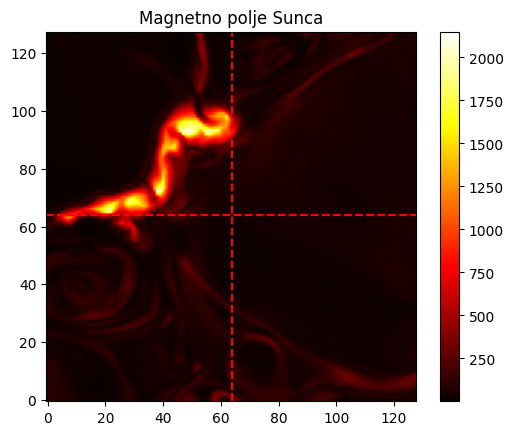

In [3]:
from astropy.io import fits

sunce = fits.open("magnetic_field_sun.fits")
podaci = sunce[0].data
dimy,dimx = podaci.shape
#centralne linije
centar_x = dimx//2
centar_y = dimy//2

plt.title('Magnetno polje Sunca')
plt.imshow(podaci,cmap = 'hot', origin = 'lower')
plt.axhline(centar_y, color='red', linestyle='--', linewidth=1.5, label="Centralna horizontalna linija")
plt.axvline(centar_x, color='red', linestyle='--', linewidth=1.5, label="Centralna vertikalna linija")
plt.colorbar()
plt.savefig('magnetno_polje.jpg')
plt.show()

In [7]:
treci_kvadrant = podaci[:centar_y, :centar_x]
cetvrti_kvadrant = podaci[:centar_y, centar_x:]
drugi_kvadrant = podaci[centar_y:, :centar_x]
prvi_kvadrant = podaci[centar_y:, centar_x:]

q2 = drugi_kvadrant
q1 = prvi_kvadrant 
q3 = treci_kvadrant
q4 = cetvrti_kvadrant

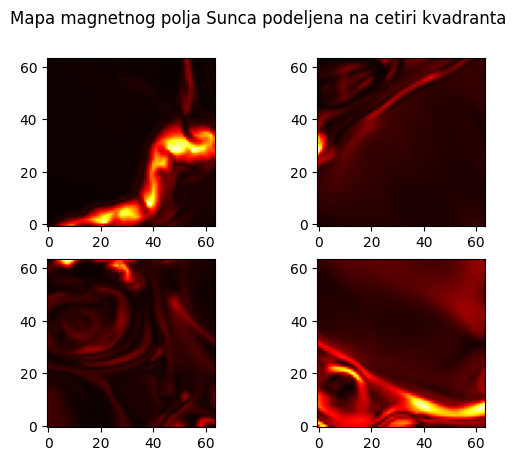

In [37]:
fig,ax = plt.subplots(2,2)

fig.suptitle('Mapa magnetnog polja Sunca podeljena na cetiri kvadranta')
ax[0][0].imshow(q2,cmap = 'hot',origin = 'lower', label ='q2')
ax[1][0].imshow(q3,cmap = 'hot',origin = 'lower', label ='q3')
ax[0][1].imshow(q1,cmap = 'hot',origin = 'lower', label ='q1')
ax[1][1].imshow(q4, cmap = 'hot',origin = 'lower', label ='q4')

#ax[0, 0].set_title('gornji levi')#q2
#ax[1, 1].set_title('donji desni')#q4

plt.show()

In [11]:
sv_q1 = np.mean(q1)
sv_q2 = np.mean(q2)
sv_q3 = np.mean(q3)
sv_q4 = np.mean(q4)

md_q1 = np.median(q1)
md_q2 = np.median(q2)
md_q3 = np.median(q3)
md_q4 = np.median(q4)

sd_q1 = np.std(q1)
sd_q2 = np.std(q2)
sd_q3 = np.std(q3)
sd_q4 = np.std(q4)

In [192]:
from tabulate import tabulate

data = [
    ["srednja vrednost", sv_q1,sv_q2,sv_q3,sv_q4 ],
    ["medijana", md_q1,md_q2,md_q3,md_q4],
    ["standardna devijacija", sd_q1,sd_q2,sd_q3,sd_q4],
]
headers = ["statistika", "q1","q2","q3","q4"]

table = tabulate(data, headers=headers, tablefmt="grid")
print(table)

+-----------------------+---------+----------+---------+---------+
| statistika            |      q1 |       q2 |      q3 |      q4 |
+=======================+=========+==========+=========+=========+
| srednja vrednost      | 65.2053 | 196.9    | 73.1613 | 51.4584 |
+-----------------------+---------+----------+---------+---------+
| medijana              | 52.2263 |  29.3903 | 55.0384 | 36.2976 |
+-----------------------+---------+----------+---------+---------+
| standardna devijacija | 50.7285 | 379.171  | 78.1357 | 45.4425 |
+-----------------------+---------+----------+---------+---------+


In [202]:
from scipy.stats import pearsonr

# Primer podataka
x = [10, 20, 3, 4, 50]
y = [5, 15, 25, 35, 45]

# Izračunaj Pearsonov koeficijent korelacije i p-vrednost
r, p_value = pearsonr(x, y)

print(f"Pearsonov koeficijent korelacije: {r:.4f}")
print(f"P-vrednost: {p_value:.4f}")


Pearsonov koeficijent korelacije: 0.5206
P-vrednost: 0.3684


In [234]:
from scipy.stats import pearsonr

r,p_vred = pearsonr(q2.flatten(),q4.flatten())

print(f"pirsonov koeficijent korelacije: {r:.4f}")
print(f"p-vrednost = { p_vred:.16f}")

p = np.corrcoef(q2.flatten(), q4.flatten())[0, 1]
print(f"prisonov koeficijent koristeci numpy funkciju: {p:.4f}")

pirsonov koeficijent korelacije: 0.1150
p-vrednost = 0.0000000000001558
prisonov koeficijent koristeci numpy funkciju: 0.1150


### 2. zadatak

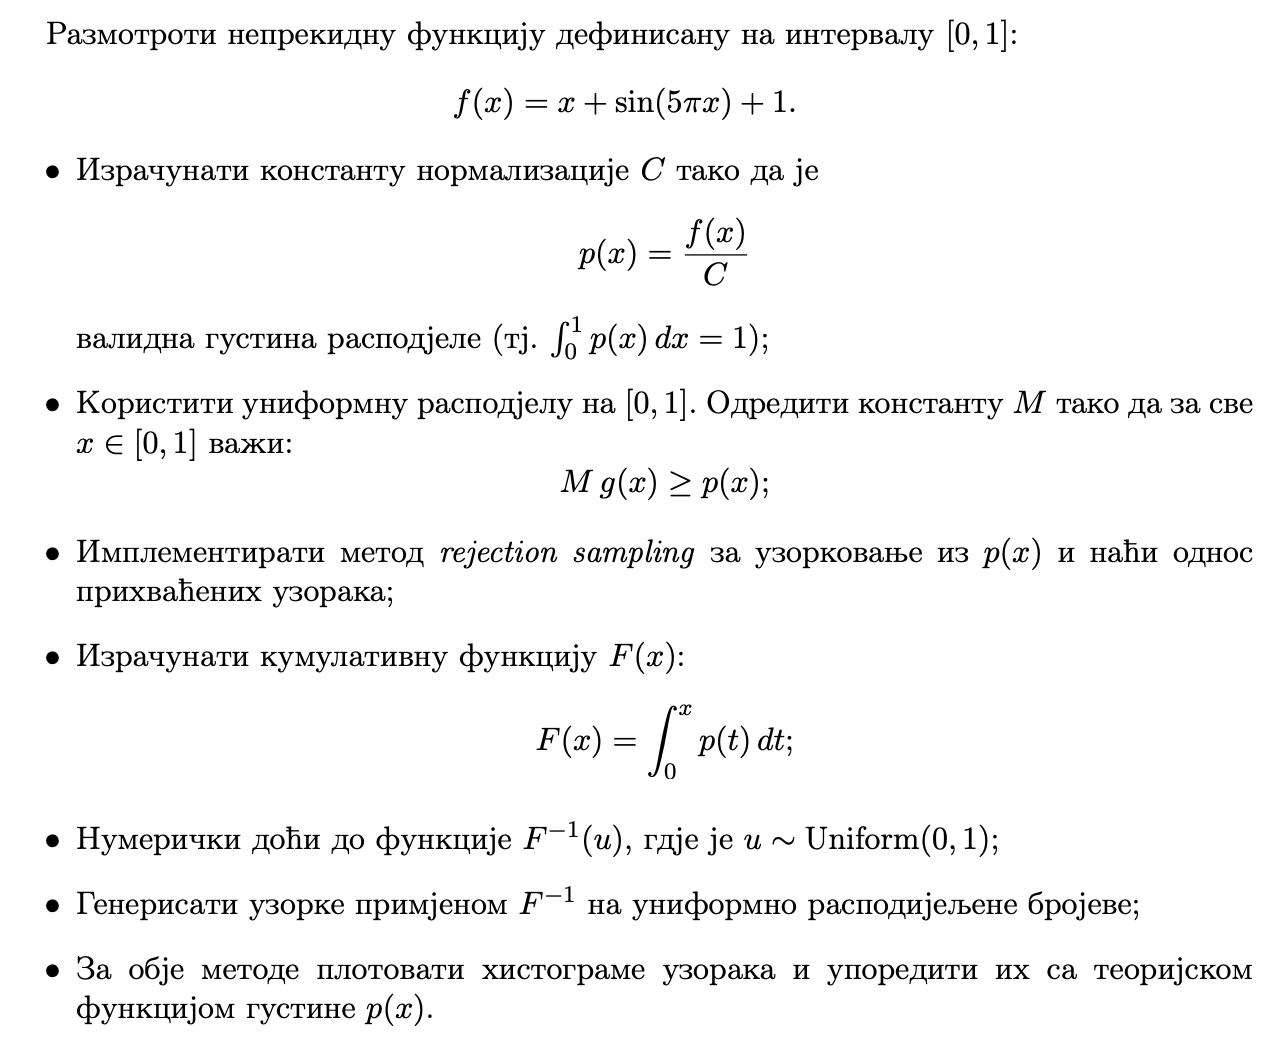

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.interpolate import interp1d

In [54]:
#data funkcija
f = lambda x: x+np.sin(5*np.pi*x)+1
#konstanta C tkd p(x)=f(x)/C
C =quad(f,0,1)[0]
#normalizovana gustina
p =lambda x: f(x) / C

In [56]:
#funkcija raspodele za uniformnu raspodelu U[0,1]
g = lambda x: 1
x_vred = np.linspace(0,1,1000)
p_vred = p(x_vred)
M = np.max(p_vred/g(x_vred))

In [62]:
#rejection sampling
N =100000
x_sample=np.random.uniform(0,1,N)
y_sample=np.random.uniform(0,M,N)
filter = x_sample[y_sample<p(x_sample)]
acceptance_ratio=len(filter)/N
print("acceptance rate:",acceptance_ratio*100,"%")

acceptance rate: 56.015 %


In [67]:
#kumulativna funkcija
cdf_vred = np.cumsum(p_vred)
cdf_vred = cdf_vred/cdf_vred[-1]
#inverzna transformacija
F_inv = interp1d(cdf_vred, x_vred, kind='linear', fill_value='extrapolate')
u_sample=np.random.uniform(0,1,len(filter)) #jer je uniformna raspodela
inv_transform=F_inv(u_sample)

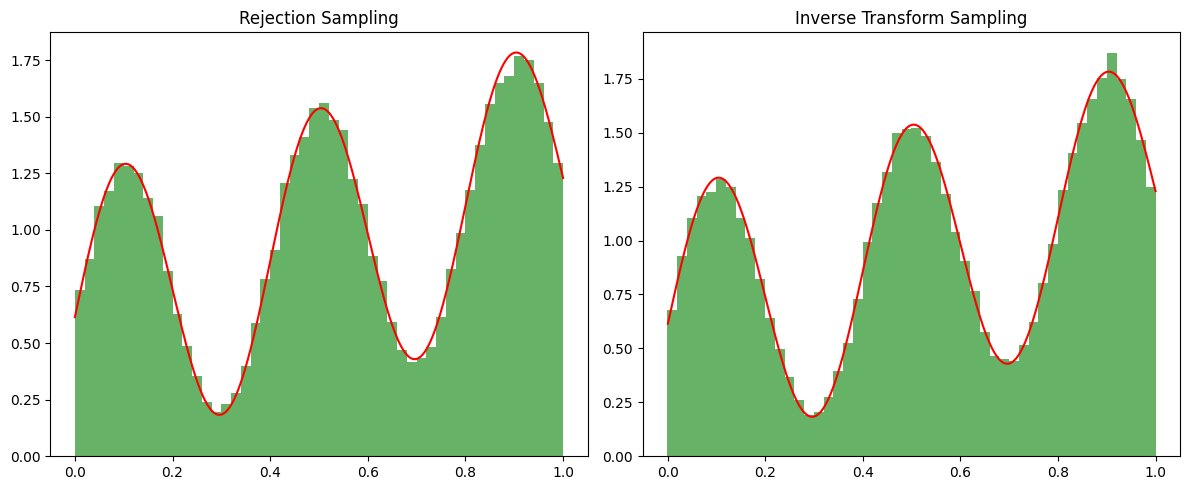

C= 1.6273239544735163
M= 1.7833107341438565
acceptance ratio= 0.56015


In [71]:
accepted = filter #u zadatku pise prihvaceni uzorci
fig,ax = plt.subplots(1,2,figsize=(12,5))

#rejection sampling
ax[0].plot(x_vred,p_vred, color = 'red')
ax[0].hist(accepted, bins=50, density=True, alpha = 0.6, color='green')
ax[0].set_title('Rejection Sampling')

#inverzna transformacija
ax[1].plot(x_vred,p_vred, color = 'red')
ax[1].hist(inv_transform, bins=50, density=True, alpha = 0.6, color='green')
ax[1].set_title('Inverse Transform Sampling')

plt.tight_layout()
plt.show()

print("C=",C)
print("M=",M)
print("acceptance ratio=",acceptance_ratio)